## Import required modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools

import warnings
warnings.filterwarnings("ignore",category=mpl.cbook.mplDeprecation)

from scipy import stats
import statsmodels.stats.multitest as smt
from math import sqrt

import _utils

import session_info
session_info.show()

## Functions

## Read in anndata

In [3]:
# anndata which includes 
adata_vis = _utils.read_visium('/nfs/team205/heart/anndata_objects/8regions/visium-OCT_adult-8reg_raw.h5ad')
adata_vis

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 55049 × 22055
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'annotation_JC', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'region_cell2loc', 'annotation_final', 'Adip1', 'Adip2', 'B', 'B_plasma', 'CD14+Mo', 'CD16+Mo', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'DC', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_atria', 'EC8_ln', 'FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6', 'ILC', 'LYVE1+IGF1+MP', 'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP', 'MAIT-like', 'Mast', 'MoMP', 'NC1', 'NC2', 'NK_CD16hi', 'NK_CD

In [4]:
adata_vis.obs['annotation_final'].value_counts()

myocardium                  35031
myocardium_ventricular       7047
epicardium_subepicardium     3207
fibrosis                     2342
cardiac_skeleton             2304
adipose_tissue               1466
node                          999
endocardium                   840
vessel                        790
myocardium_atrial             527
AV_bundle                     452
nerve                          44
Name: annotation_final, dtype: int64

## Correlation of Ig genes in epicardium

In [5]:
IGs=['IGHG1','IGHG3','IGHG4','IGHA1'] # significantly enriched Ig genes

# epicardium spots
df=adata_vis[adata_vis.obs['annotation_final']=='epicardium_subepicardium'].to_df()
print(len(df))

ig_df=pd.DataFrame(list(itertools.combinations_with_replacement(IGs,2)))

for i in ig_df.index:
    ig0=ig_df.loc[i,0]
    ig1=ig_df.loc[i,1]
    
    df_s=df[(df[ig0]>0)|(df[ig1]>0)]
    corr,pval=stats.spearmanr(df_s[ig0], df_s[ig1])
    
    ig_df.loc[i,'corr']=corr.copy()
    ig_df.loc[i,'pval']=pval.copy()
    
    ig_df.loc[i,'0_pos-rate']=sum(df[ig0]>0)/len(df)
    ig_df.loc[i,'1_pos-rate']=sum(df[ig1]>0)/len(df)
    ig_df.loc[i,'pos-rate']=(sum(df[ig0]>0)/len(df))*(sum(df[ig1]>0)/len(df))

ig_df['pval_adj']=smt.multipletests(ig_df['pval'], method='bonferroni', is_sorted=False, returnsorted=False)[1]

3207


In [9]:
ig_df[(ig_df[1]=='IGHA1')]

,0,1,corr,pval,0_pos-rate,1_pos-rate,pos-rate,pval_adj
3,IGHG1,IGHA1,-0.660805,3.751870e-42,0.054568,0.054568,0.002978,3.751870e-41
6,IGHG3,IGHA1,-0.589990,3.692261e-46,0.105706,0.054568,0.005768,3.692261e-45
8,IGHG4,IGHA1,-0.660426,3.259396e-57,0.095104,0.054568,0.005190,3.259396e-56
9,IGHA1,IGHA1,1.000000,0.000000e+00,0.054568,0.054568,0.002978,0.000000e+00


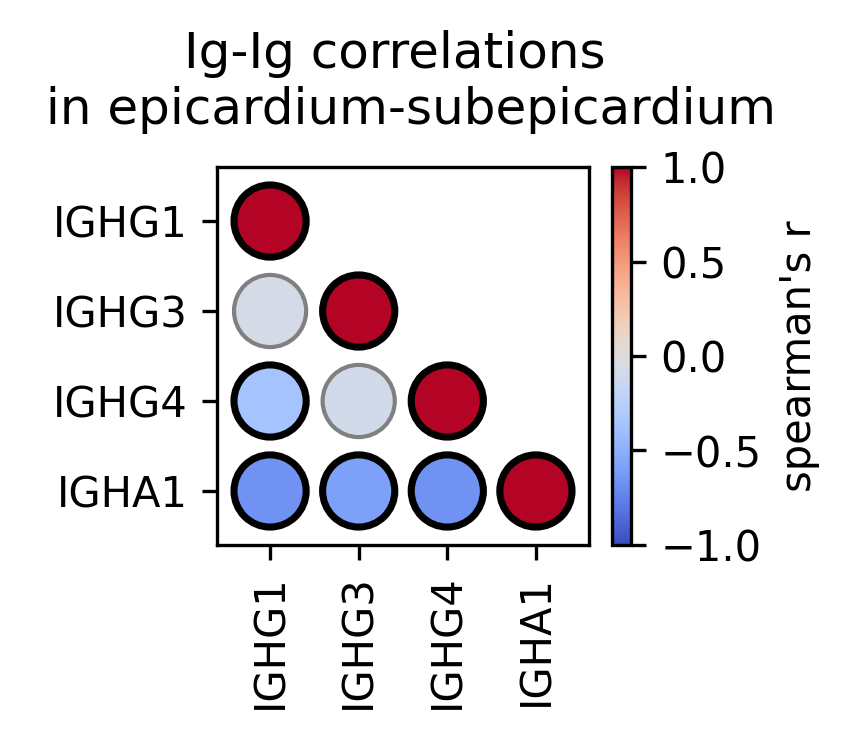

In [20]:
# plot
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = 2.8,2.6
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.titley'] = 1.05

edgecolor=['black' if x<0.05 else 'grey' for x in ig_df['pval_adj']]
linewidths=[1.7 if x<0.05 else 1 for x in ig_df['pval_adj']]
plt.scatter(x=ig_df[0],y=ig_df[1],s=300,c=ig_df['corr'],
            cmap='coolwarm',edgecolor=edgecolor,linewidths=linewidths)
plt.xticks(rotation=90)
plt.clim(-1, 1)
plt.margins(x=0.2,y=0.2)
plt.gca().invert_yaxis()
plt.title('Ig-Ig correlations \n in epicardium-subepicardium')

cbar=plt.colorbar()
cbar.set_label("spearman's r", rotation=90)

plt.tight_layout()
plt.savefig('/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/figures/IGs_correlation_in-epi.pdf')
plt.show()